# Mini-projets UE14 Mines ParisTech 2021 S18 et S19
Ce notebook contient les informations et les données nécessaires aux calculs proposés dans les sujets 18 et 19 des mini-projets de l'UE14 2021.

Liens vers les descriptions:
- Sujet 17 "Comment l’empreinte carbone des pays est-elle calculée ?" https://docs.google.com/document/d/1GijTxGaNKpwpeuGNfZtfMtOGAOAMh2EOAmpkwYa-2fw/edit
- Sujet 18 "Réconcilier les méthodes de calcul d’empreinte carbone" https://docs.google.com/document/d/19Fh1tyZqaGFunaKeC_HXfsHgXBtz8TAHyeoS2fcGRxE/edit

Pour toute question: <thomas.gibon@list.lu>

Ce dont vous aurez besoin pour ce mini-projet:

1. l'installation de la distribution Anaconda (ou Miniconda), qui contient déjà tous les modules Python de base pour les calculs (numpy, pandas, ...), les instructions d'installation sont disponibles [ici](https://docs.anaconda.com/anaconda/install/index.html).

2. un environnement `conda` dédié au projet (pas nécessaire, mais recommandé) en procédant ainsi:
    - ouvrir un terminal (`cmd` sous Windows),
    - créer l'environnement en ligne de commande `conda create -n io`,
    - activer l'environnement `activate io`
    
3. installer `pymrio` à partir de https://anaconda.org/conda-forge/pymrio
    - en ligne de commande, s'assurer que l'environnement `io` est activé
    - installer le package `conda install -c conda-forge pymrio`

In [1]:
import pymrio as mr
import pandas as pd
import numpy as np
from scipy.linalg import block_diag
import seaborn as sns
import matplotlib
import matplotlib.pyplot as plt
import os
%matplotlib inline

## Télécharger la base de données EXIOBASE
La première chose à faire est de récupérer la ou les tables input-output EXIOBASE, à partir du dernier dépôt Zenodo.
Une fois les données télécharger, les importer, et vous êtes prêts à les utiliser.

In [2]:
doi = '10.5281/zenodo.4588235'

Choisir le répertoire d'installation.

In [3]:
EXIOBASE_PATH = '../EXIOBASE/' # ne pas hésiter à changer

In [4]:
year = 2019
filename = EXIOBASE_PATH+'IOT_{}_ixi.zip'.format(year)

Lancer le téléchargement avec la commande dédiée.

Attention, les données sont volumineuses, si vous avez déjà téléchargé une fois, il est inutile de recommencer. Préférer le réseau de l'école si possible (sauf si vous avez la fibre...).

In [5]:
if not os.path.isfile(filename):
    exio_meta = mr.download_exiobase3(
        storage_folder=EXIOBASE_PATH, # chemin d'installation
        system='ixi',                 # choisir table produit-par-produit (pxp) ou industrie-par-industrie (ixi)
        years=2019,     # quelles années télécharger
        doi=doi                       # adresse du dépôt
    )

Une fois les fichiers téléchargés, il reste à importer la base de données `pymrio`. Choisir une année en particulier (2019 est recommandé).

In [6]:
io = mr.parse_exiobase3(path=filename)

Importer le fichier de population (intéressant pour calculer les empreintes par personne)

In [7]:
population = pd.read_csv(EXIOBASE_PATH+'exiobase_population.txt',sep='\t',index_col=0)
io.population=pd.DataFrame(columns=['population'], data=population.loc[year].values, index=population.columns).T

Enfin, le système doit être "calculé", pour déterminer, entre autres, les résultats d'empreinte environnementale. 

In [8]:
io.calc_all()

## Familiarisation avec la structure
L'objet créé `io` contient toute la structure de la table input-output multirégionale, c'est-à-dire la table complète des coefficients/transactions monétaires entre secteurs et pays. Ce sont ces coefficients qui vont nous permettre de retracer les émissions de GES entre production et consommation.

Un coefficient $a_{ij}$ représente toujours une transaction du secteur i vers le secteur j. Tout vecteur colonne représente donc l'ensemble des intrants pour un secteur donné (comme une recette de cuisine donne les ingrédients).

**Toutes les matrices monétaires sont organisées de la même façon, avec un index (pays, secteur) pour les lignes et les colonnes, en M€ ou M€/M€. Les matrices contenant les émissions ont simplement une liste d'émissions en ligne, et (pays, secteur) en colonne.**

### Pays et régions
EXIOBASE contient les données de 49 zones géographiques, dont l'UE 27+1 en début de liste et 5 zones "reste" (`W...`) en fin de liste (Asie, Amérique Latine, Europe, Afrique, monde).

In [9]:
io.get_regions()

Index(['AT', 'BE', 'BG', 'CY', 'CZ', 'DE', 'DK', 'EE', 'ES', 'FI', 'FR', 'GR',
       'HR', 'HU', 'IE', 'IT', 'LT', 'LU', 'LV', 'MT', 'NL', 'PL', 'PT', 'RO',
       'SE', 'SI', 'SK', 'GB', 'US', 'JP', 'CN', 'CA', 'KR', 'BR', 'IN', 'MX',
       'RU', 'AU', 'CH', 'TR', 'TW', 'NO', 'ID', 'ZA', 'WA', 'WL', 'WE', 'WF',
       'WM'],
      dtype='object', name='region')

### Secteurs
163 secteurs industriels sont disponibles. Les tableaux entrées-sorties ont donc une taille de $(49 × 163) × (49 × 163) = 7987 × 7987$.

In [10]:
list(io.get_sectors())

['Cultivation of paddy rice',
 'Cultivation of wheat',
 'Cultivation of cereal grains nec',
 'Cultivation of vegetables, fruit, nuts',
 'Cultivation of oil seeds',
 'Cultivation of sugar cane, sugar beet',
 'Cultivation of plant-based fibers',
 'Cultivation of crops nec',
 'Cattle farming',
 'Pigs farming',
 'Poultry farming',
 'Meat animals nec',
 'Animal products nec',
 'Raw milk',
 'Wool, silk-worm cocoons',
 'Manure treatment (conventional), storage and land application',
 'Manure treatment (biogas), storage and land application',
 'Forestry, logging and related service activities (02)',
 'Fishing, operating of fish hatcheries and fish farms; service activities incidental to fishing (05)',
 'Mining of coal and lignite; extraction of peat (10)',
 'Extraction of crude petroleum and services related to crude oil extraction, excluding surveying',
 'Extraction of natural gas and services related to natural gas extraction, excluding surveying',
 'Extraction, liquefaction, and regasificat

In [11]:
io.Z.shape

(7987, 7987)

### Z: consommation intermédiaire
Cette matrice présente la consommation intermédiaire complète entre secteurs, en M€.

Par exemple: le secteur de l'élevage bovin français a dépensé 1214 M€ en produits cultivés (non-blé, non-riz) en 2019, ainsi que 710 M€ en produits de gros, 580 M€ en produits de l'industrie agro-alimentaire, etc. À noter, 258 M€ de produits cultivés ont été importés de la région "reste de l'Afrique" (`WF`).

In [12]:
io.Z['FR','Cattle farming'].sort_values(ascending=False).head(8)

region  sector                                                                                             
FR      Cultivation of crops nec                                                                               1213.973491
        Wholesale trade and commission trade, except of motor vehicles and motorcycles (51)                     709.813893
        Processing of Food products nec                                                                         581.217679
        Retail trade, except of motor vehicles and motorcycles; repair of personal and household goods (52)     501.188476
        Cultivation of cereal grains nec                                                                        384.730878
        Manufacture of beverages                                                                                277.375923
WF      Cultivation of crops nec                                                                                257.778025
FR      Cultivation of wheat   

### A: coefficients de consommation intermédiaire
La matrice `A` contient les coefficients de consommation intermédiaire, en €/€.

Par exemple, quels sont les trois secteurs principaux composant les dépenses du secteur de l'électricité au gaz en France en 2019?

In [13]:
io.A['FR','Production of electricity by gas'].sort_values(ascending=False).head(3)

region  sector                                                                                       
FR      Manufacture of gas; distribution of gaseous fuels through mains                                  0.525974
NO      Extraction of natural gas and services related to natural gas extraction, excluding surveying    0.186255
DE      Extraction of natural gas and services related to natural gas extraction, excluding surveying    0.139489
Name: (FR, Production of electricity by gas), dtype: float64

Interprétation : pour fournir 1€ d'électricité au gaz à l'économie, les coûts sont de :
- 0.53€ en raffinage, transmission et distribution, en France,
- 0.19€ de gaz importé de Norvège,
- 0.14€ de gaz importé d'Allemagne.

De la même façon, on peut déterminer quels secteurs ont l'électricité au gaz française parmi leurs intrants principaux. Sans surprise, cela devrait être la transmission et la distribution d'électricité.

In [14]:
io.A.loc['FR','Production of electricity by gas'].sort_values(ascending=False).head(3)

region  sector                                             
FR      Distribution and trade of electricity                  0.075094
        Transmission of electricity                            0.073398
        Recreational, cultural and sporting activities (92)    0.006013
Name: (FR, Production of electricity by gas), dtype: float64

### Y: demande finale
La demande finale contient les informations de consommation finale des ménages, des ONGs, et du gouvernement, ainsi que les changements d'inventaire ou la consommation de capital.

Par exemple, quels sont les secteurs de dépense principaux des ménages allemands ?

In [15]:
io.Y['DE','Final consumption expenditure by households'].sort_values(ascending=False).head()

region  sector                                                             
DE      Real estate activities (70)                                            343369.173295
        Hotels and restaurants (55)                                            108577.573264
        Post and telecommunications (64)                                        89473.932576
        Financial intermediation, except insurance and pension funding (65)     65978.802344
        Health and social work (85)                                             65977.997346
Name: (DE, Final consumption expenditure by households), dtype: float64

Interprétation : en 2019 les ménages allemands ont dépensé 343 milliards d'euros dans le marché de l'immobilier, 109 G€ en hotels et restaurants, 89 G€ en frais de télécommunication divers, etc.

### L: coefficients directs et indirects (inverse de Leontief)
Cette matrice est la clé de voûte de tout le système entrée-sortie. Son développeur, Wassily Leontief, s'est vu [décerner le "prix Nobel" d'économie en 1973](https://www.economie.gouv.fr/facileco/wassily-leontief).

La principale propriété de cette matrice, c'est qu'elle donne non seulement les coefficients d'"input" directs pour une industrie, par exemple le béton pour la construction, mais aussi la somme de la demande en béton nécessaire aux autres inputs de la construction, et celle des inputs des inputs, etc. couvrant ainsi la totalité de la demande en béton directe et indirecte pour satisfaire la demande de construction.

Illustrons cet exemple par le calcul:

In [16]:
index=((slice(None),'Manufacture of cement, lime and plaster'),
         ('FR','Construction (45)'))

In [17]:
# facteurs directs
direct = io.A.loc[index].sort_values(ascending=False).head()

In [18]:
# facteurs directs ET indirects
direct_indirect = io.L.loc[index].sort_values(ascending=False).head()

In [19]:
# calculons la différence
indirect = (direct_indirect - direct)

<AxesSubplot:xlabel='region'>

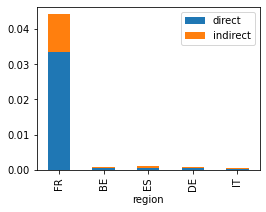

In [20]:
pd.concat([direct,indirect],axis=1,keys=('direct','indirect')).sort_values(by='direct',ascending=False).head().droplevel(1).plot(kind='bar',stacked=True,figsize=(4,3))

Interprétation : le secteur de la construction en France requiert un peu plus de 0.03€ de ciment (FR) par € fourni à l'économie, mais plus de 0.04€ en incluant le ciment nécessaire à tous les autres secteurs requis pour la construction.

### Matrices "satellites"
Les matrices satellites sont les homologues de Z et A, mais en termes de facteurs de production, de valeur ajoutée, et d'émissions de substances.

#### F: facteurs de production
Les facteurs de production sont simplement les "ressources primaires" (capital, emploi, ressources naturelles, émissions de substances). Cette matrice constitue l'interface entre l'économie et le reste de l'environnement.

On peut y trouver les informations sur les salaires, par exemple la masse salariale du secteur de la santé au Royaume-Uni se composait de 4.6/59/89 milliards d'euros en emplois non-qualifiés/intermédiaires/qualifiés en 2019. Ce secteur a par ailleurs émis 2.2 millions de tonnes de CO2 (en émissions directes dues à la combustion de carburants fossiles).

In [21]:
io.satellite.F['GB','Health and social work (85)'].head()

stressor
Taxes less subsidies on products purchased: Total                                                 6359.466983
Other net taxes on production                                                                      373.229764
Compensation of employees; wages, salaries, & employers' social contributions: Low-skilled        4589.108985
Compensation of employees; wages, salaries, & employers' social contributions: Medium-skilled    59381.604405
Compensation of employees; wages, salaries, & employers' social contributions: High-skilled      89403.465875
Name: (GB, Health and social work (85)), dtype: float64

In [22]:
io.satellite.F.loc['CO2 - combustion - air',('GB','Health and social work (85)')]

2227922410.73

#### S: coefficients
Les coefficients satellites sont l'équivalent de la matrice A pour les facteurs de production. Par exemple, combien de CO2 a été émis pour fournir 1€ de services de santé au Royaume-Uni ?

In [23]:
io.satellite.S.loc['CO2 - combustion - air',('GB','Health and social work (85)')]

6620.92541171

## Calculs d'impact
Les matrices satellite D sont celles qui nous intéressent pour ce projet.

- D_pba: inventaire national (production-based accounts),
- D_cba: empreinte (consumption-based accounts).

Elles se déclinent en
- ..._reg: résultats agrégés au niveau de la région
- ..._cap: résultats par personne

### Émissions territoriales

In [24]:
# D_pba: production-based account
# Cette matrice nous donne tout simplement les facteurs de production, c'est l'équivalent de F

# Émissions directes de CO2 par secteur
io.satellite.D_pba.loc['CO2 - combustion - air']

region  sector                                             
AT      Cultivation of paddy rice                              0.000000e+00
        Cultivation of wheat                                   2.621157e+08
        Cultivation of cereal grains nec                       2.353410e+08
        Cultivation of vegetables, fruit, nuts                 1.043426e+08
        Cultivation of oil seeds                               4.583117e+07
                                                                   ...     
WM      Activities of membership organisation n.e.c. (91)      2.484401e+08
        Recreational, cultural and sporting activities (92)    4.717884e+08
        Other service activities (93)                          3.388487e+08
        Private households with employed persons (95)          7.695058e+07
        Extra-territorial organizations and bodies             0.000000e+00
Name: CO2 - combustion - air, Length: 7987, dtype: float64

Affichons les inventaires de CO2 pour tous les pays de la base de données.

<AxesSubplot:ylabel='Émissions de CO2, 2019, Mt'>

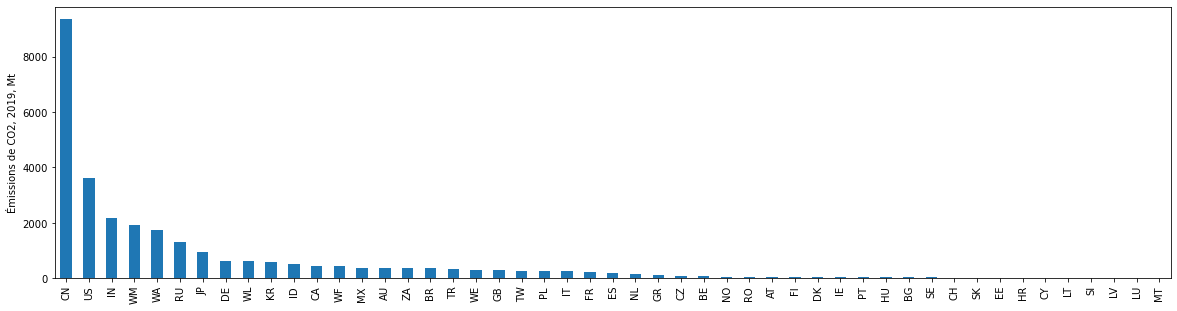

In [25]:
emissions_CO2_inventaire = io.satellite.D_pba_reg.loc['CO2 - combustion - air']*1e-9
emissions_CO2_inventaire.sort_values(ascending=False).plot(kind='bar', figsize=(20,5), ylabel='Émissions de CO2, 2019, Mt')

In [26]:
emissions_CO2_inventaire['FR']

229.88587851000003

La valeur pour la France semble faible si on est déjà familier avec [les chiffres (305 Mt en 2019)](https://www.statistiques.developpement-durable.gouv.fr/sites/default/files/2020-12/datalab_81_chiffres_cles_du_climat_edition_2021.pdf?page=44), pourquoi ?

D'abord il faut considérer les gaz à effet de serre principaux.

In [27]:
GWP_factors_all = pd.read_excel(EXIOBASE_PATH + 'GWP100_EXIOBASE_factors.xlsx',index_col=0,squeeze=True)
GWP_factors = GWP_factors_all[['CO2 - combustion - air','CH4 - combustion - air','N2O - combustion - air']]
GWP_factors

CO2 - combustion - air      1.0
CH4 - combustion - air     36.0
N2O - combustion - air    298.0
Name: Climate change, short term (kg CO2 eq (short)), dtype: float64

In [28]:
GWP_factors_all = GWP_factors_all.reindex(io.satellite.D_pba_reg.index, fill_value=0)
GWP_factors = GWP_factors.reindex(io.satellite.D_pba_reg.index, fill_value=0)
emissions_GES_inventaire = GWP_factors.dot(io.satellite.D_pba_reg)*1e-9

In [29]:
emissions_GES_inventaire['FR']

233.74170233575614

Un peu mieux. Ensuite il faut y ajouter les émissions directes de la consommation finale (ce que les ménages ou l'administration émettent via l'utilisation de voitures, chauffage, ...). Ces valeurs sont contenues dans `F_Y`.

In [30]:
emissions_GES_finales = GWP_factors.dot(io.satellite.F_Y).groupby('region').sum()*1e-9

In [31]:
(emissions_GES_inventaire + emissions_GES_finales)['FR']

312.0015119720357

Voilà qui est plus en accord avec les estimations du SDES.

### Empreinte carbone
On appelle l'empreinte carbone la somme des émissions liées à la consommation finale, en gaz à effet de serre ("carbone" étant un abus de langage). C'est `D_cba` qui nous donne les valeurs.

Ce calcul s'appuie sur l'inverse de Leontief, qui permet de remonter les chaînes de valeur jusqu'à la production primaire pour chaque secteur, y compris via les échanges entre pays.

Formellement, le calcul est 

$$D_{cba} = S L \hat{y}$$

Même principe qu'au-dessus pour le calcul en GES.

<AxesSubplot:ylabel='Émissions de GES, 2019, Mt CO2 eq.'>

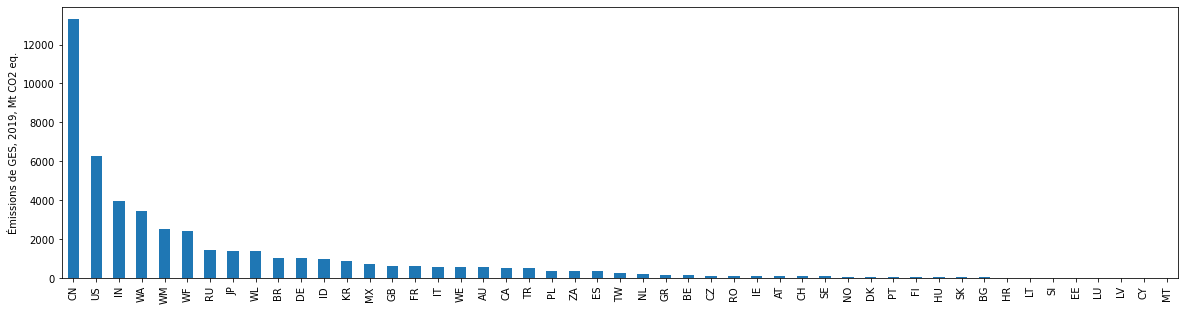

In [32]:
emissions_GES_empreinte = GWP_factors_all.dot(io.satellite.D_cba_reg)*1e-9
emissions_GES_empreinte.sort_values(ascending=False).plot(kind='bar', figsize=(20,5), ylabel='Émissions de GES, 2019, Mt CO2 eq.')

Empreinte carbone de la France en 2019, en Mt CO2 eq.

In [33]:
(emissions_GES_empreinte + emissions_GES_finales)['FR']

686.0664270402981

### Comparaison émissions territoriale/empreinte

In [45]:
comp = pd.concat([(emissions_GES_inventaire + emissions_GES_finales),
           (emissions_GES_empreinte + emissions_GES_finales)],
          keys=('Inventaire national','Empreinte'),
          axis=1).sort_values(by='Empreinte')

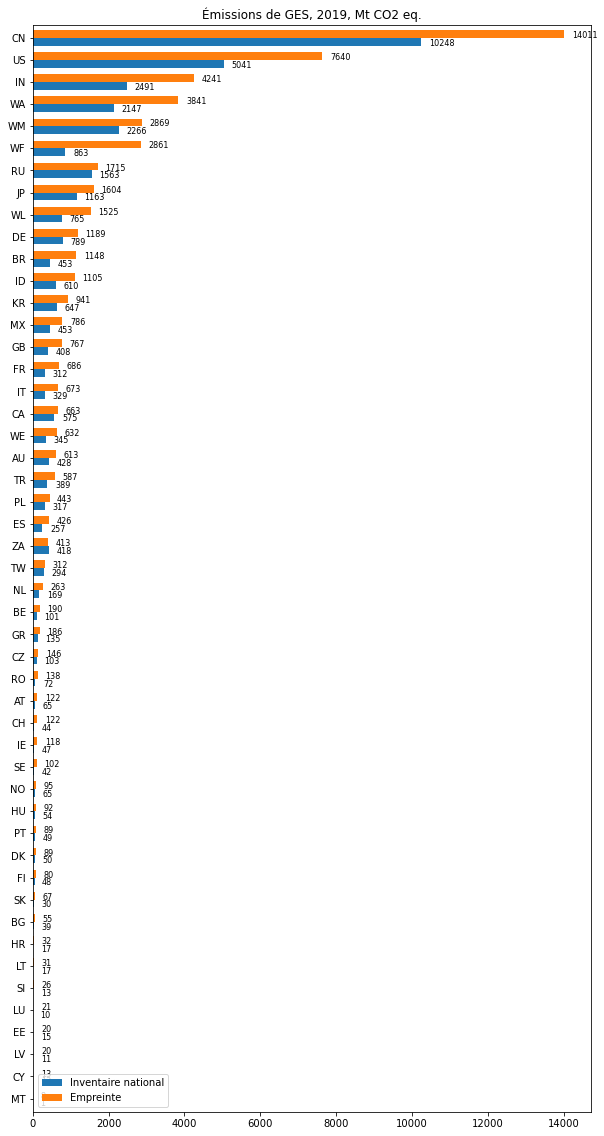

In [54]:
ax = comp.plot(kind='barh', figsize=(10,20), title='Émissions de GES, 2019, Mt CO2 eq.', width=0.7)

for p in ax.patches:
    ax.annotate(f'{p.get_width():.0f}', (p.get_width()+200, p.get_y()), fontsize=8)

### Idées d'exercice.

Groupe S18: Questions données
- Depuis quels principaux pays la France importe-t-elle son empreinte carbone ?
- Quels secteurs de l'économie importent le plus ? le moins ?
- Quels sont les p

Groupe S19
- D'autres sources d'empreinte existent, notamment: 
    - Eora database https://worldmrio.com/
    - Global Carbon Project https://doi.org/10.5194/essd-12-3269-2020
    - Calculs du SDES https://www.statistiques.developpement-durable.gouv.fr/sites/default/files/2020-12/datalab_81_chiffres_cles_du_climat_edition_2021.pdf?page=44
    ...en quoi ces sources diffèrent-elles ?
- Quels sont les intérêts